# 3.- Running the MCMC

Nauyaca uses a Parallel-Tempering sampling algorithm to explore the parameter space at different walker temperatures. This method allows the walkers do not get stuck in local high probability regions due to the exchange between high and low temperature walkers. The posteriors are drawn from the walkers at temperature 0.

Let's import the main modules for the MCMC analisys.

In [10]:
import nauyaca_local as nau

from nauyaca_local import MCMC

from nauyaca_local import plots # Useful pre-fabricated plots

import matplotlib.pyplot as plt
import numpy as np

As before, let's load the Planetary System object

In [2]:
PS = nau.utils.load_pickle('SystemX.pkl')
print(PS)


 =========== Planetary System Summary =========== 
System: SystemX
Mstar: 0.91 Msun |  Rstar: 1.18 Rsun
Number of planets: 2
Planet information:
------
Planet: Planet-b
  Boundaries:
    mass: [0.1, 20.0]  [M_earth]
    period: [33.616, 33.618]  [d]
    ecc: [1e-05, 0.2]  
    inclination: [88, 90.0]  [deg]
    argument: [0.0, 360]  [deg]
    mean_anomaly: [0.0, 360]  [deg]
    ascending_node: [180.0, 180]  [deg]
  TTVs: True
------
Planet: Planet-c
  Boundaries:
    mass: [0.1, 20]  [M_earth]
    period: [73.506, 73.508]  [d]
    ecc: [1e-05, 0.2]  
    inclination: [88, 90.0]  [deg]
    argument: [0.0, 360]  [deg]
    mean_anomaly: [0.0, 360]  [deg]
    ascending_node: [90.0, 270.0]  [deg]
  TTVs: True

Total time of TTVs data: 996.625070414 [days]
First planet (ID) in transit: Planet-b
Reference epoch of the solutions: 21.0 [JD]
Time span of TTVs simulations: 1004.89382252642
Timestep of the simulations: None [days]


In [3]:
# Reference time
PS.T0JD = 0.0

PS.T0JD

0.0

Now let's define the main parameters to run the MCMC. We will run the MCMC along 1000 iterations saving each 10 steps.

In [4]:
Ntemps = 7       # Number of temperatures
Nwalkers = 100    # Number of walkers per temperature
Tmax = None       # Maximum temperature. If None, then Parallel-Tempering chose an appropiate maximum temperature

itmax = 10000      # Maximum number of steps
conver_steps = 25 # Number of steps to save the chains

## 3.1 Initializing walkers

To initialize the MCMC we should provide an initial array of the location of the walkers in the parameter space. To do so, Nauyaca provides 3 forms of easily initialize walkers through the 'initial_walkers' function in the 'utils' module. Additionally, you can provide your own walkers' initial position as long as they are inside the valid boundaries. 

IMPORTANT: Initial walkers should be provided in an array of shape (ntemps, nwalkers, ndim), where ndim is the number of dimensions (mass1, period1...)

Let's generate these 3 ways of initial walkers and plot them using the 'plots' module

In [5]:
from nauyaca_local.utils import initial_walkers

**1) Uniform distribution**

For all the planetary parameters, initialize walkers from an uniform distribution
along the stablished boundaries for each planet. Using this option is unnecesary to run optimizers previously.

In [6]:
walkers_uniform = initial_walkers(PS, distribution="Uniform", ntemps=Ntemps, nwalkers=Nwalkers)


--> Selected distribution: Uniform


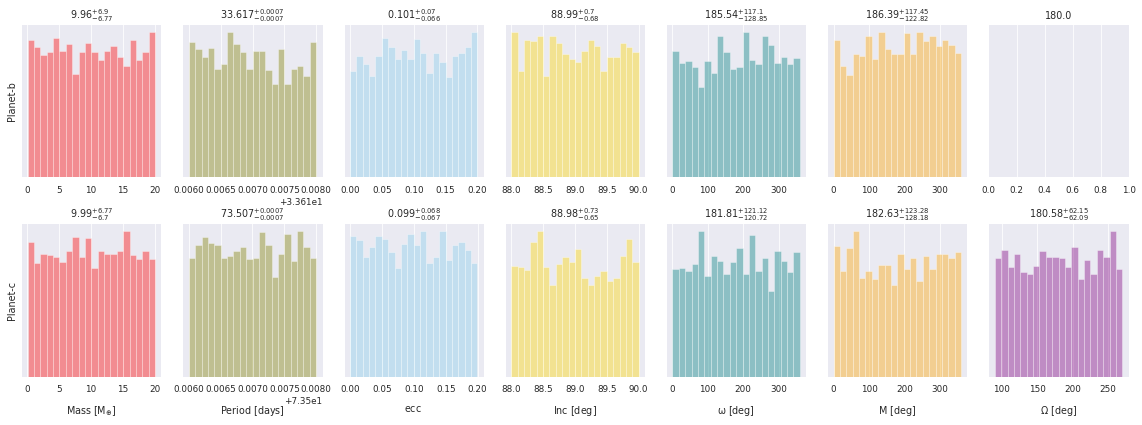

In [7]:
plots.plot_hist(PS, chains=walkers_uniform)

For the two other ways, let's load the results from the optimizers that we got in the previous tutorial.

In [6]:
import numpy as np

RESULTS_opt = np.genfromtxt(f'{PS.system_name}_cube.opt').tolist()
len(RESULTS_opt)

160

(array([32., 11., 10.,  4.,  3.,  2.,  4.,  7.,  1.,  6.]),
 array([  -96.62696869,  1273.79267266,  2644.21231401,  4014.63195536,
         5385.0515967 ,  6755.47123805,  8125.8908794 ,  9496.31052074,
        10866.73016209, 12237.14980344, 13607.56944479]),
 <a list of 10 Patch objects>)

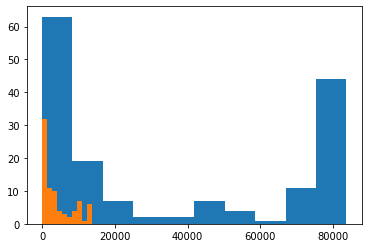

In [9]:
# Visualize the chi2 distribution
plt.hist(np.array(RESULTS_opt).T[0] )

thrs = 0.5

# Helps to visualize the choice of threshold
r2 = sorted(RESULTS_opt, key=lambda x: x[0])
plt.hist(np.array(r2).T[0][:int(len(RESULTS_opt)*thrs)])

**2) Gaussian distribution**

Provide the results directly from the optimizers (through opt_data argument) and construct a gaussian with the mean and standard deviation of the solutions along each dimension. In opt_data, pass RESULTS_opt (from optimizers or from file). Argument 'treshold' selects a fraction of the best solutions and discard the rest. For example, treshold=.4 takes the best 40% of the solutions according to the $\chi^2$

In [9]:
walkers_gaussian = initial_walkers(PS, distribution="Gaussian", 
                                   ntemps=Ntemps, nwalkers=Nwalkers, 
                                   opt_data=RESULTS_opt, threshold=0.4) 


--> Selected distribution: Gaussian
    192 of 480 solutions taken


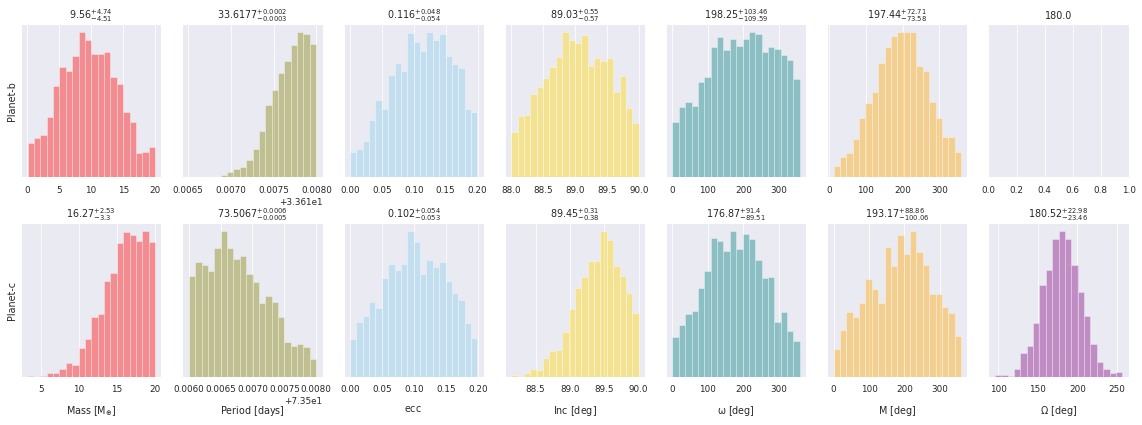

In [10]:
plots.plot_hist(PS, chains=walkers_gaussian)

**3) Picked distribution**

Provide directly the results of the optimizers (throuhgt opt_data argument) and construct a discrete distribution by randomly selecting exact values of the optimizer solutions. In opt_data, pass RESULTS_opt (from optimizers) or results_opt (from file) treshold selects a fraction of the best solutions and discard the rest. For example, .8 takes the 80% of the solutions with the best $\chi^2$

In [10]:
walkers_picked = initial_walkers(PS, distribution="smart", 
                                 ntemps=Ntemps, nwalkers=Nwalkers, 
                                 opt_data=RESULTS_opt, threshold=.5)


--> Selected distribution: smart
    80 of 160 solutions taken


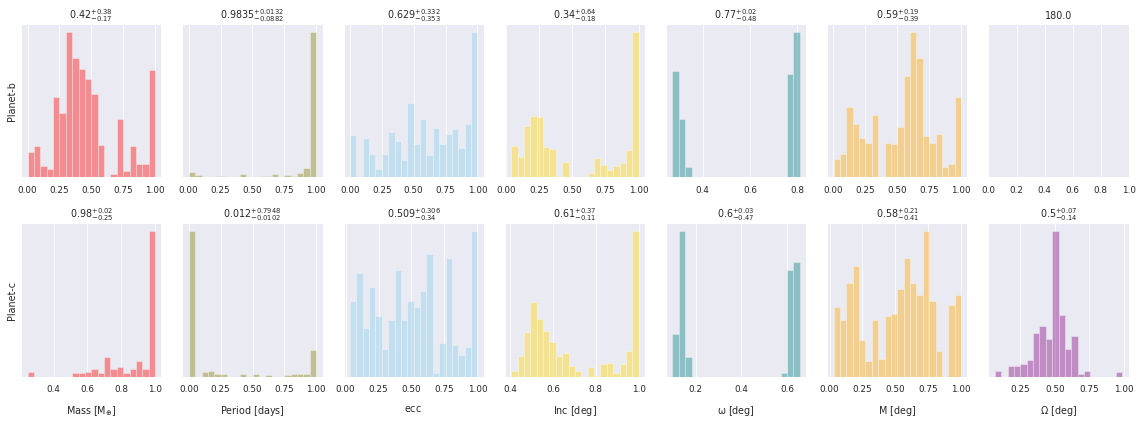

In [11]:
plots.plot_hist(PS, chains=walkers_picked)

#### 4) Smart distribution

In [39]:
walkers_smart = initial_walkers(PS, distribution="Smart",
                    ntemps=Ntemps, nwalkers=Nwalkers,
                    opt_data=RESULTS_opt, threshold=0.6)  



--> Selected distribution: Smart
    288 of 480 solutions taken


In [40]:
# Temporal
bi, bf = np.array(PS.bounds).T 
walkers_s2 = np.zeros_like(walkers_smart) # []

for t in range(Ntemps):
    flat_params = walkers_smart[t] # una misma temperatura
    #wk_tmp = []
    
    for i_fp, fp  in enumerate(flat_params):
        #wk_tmp.append( (fp-bi)/(bf-bi)  )
        
        walkers_s2[t,i_fp,:]  = (fp-bi)/(bf-bi)
walkers_s2.shape

(16, 100, 13)

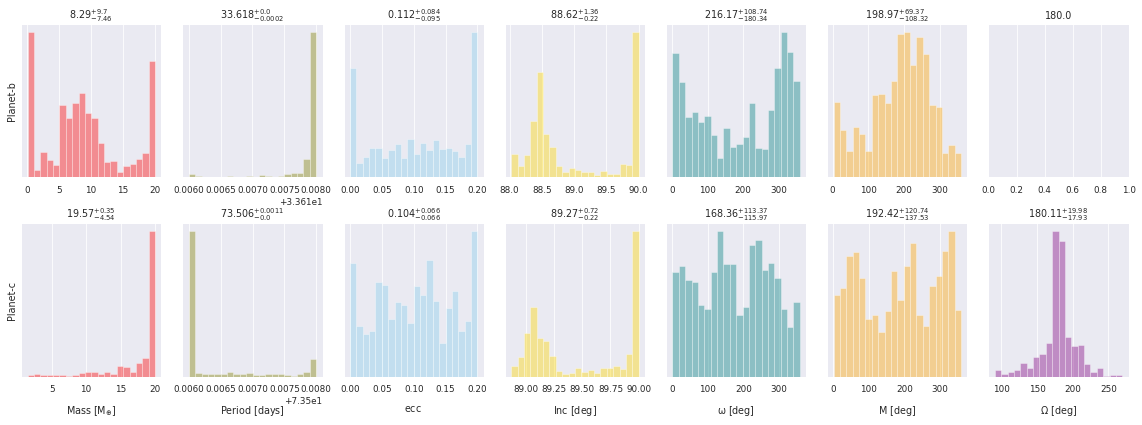

In [41]:
plots.plot_hist(PS, chains=walkers_smart)

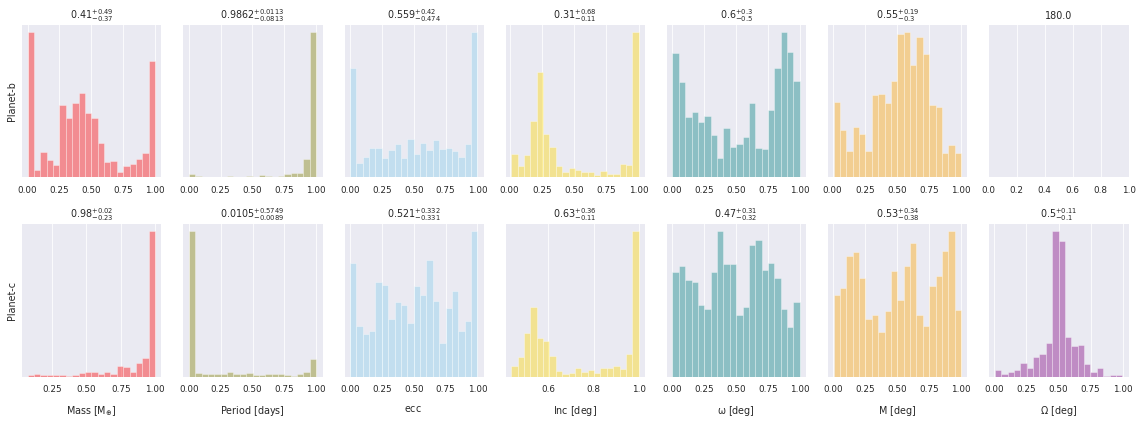

In [42]:
plots.plot_hist(PS, chains=walkers_s2)

Note that if there are constant values in the planet's boundaries, then that parameter will be skipped and values will not appear in the initial walkers

## 3.2 Running the MCMC

Let's run the MCMC using the initial walkers from the picked distribution generated above. Also provide the necessary keyword arguments

In [11]:
RESULTS_mcmc = MCMC.run_mcmc(
            PS,                             # Planetary System object
            pop0 = walkers_picked,        # Initial population of walkers 
            nwalkers = Nwalkers,            # Number of walkers
            ntemps = Ntemps,                # Number of temperatures
            Tmax = Tmax,                    # Maximum temperature
            betas = None,                   # Betas is an array of inverse temperatures
            Itmax = itmax,                  # Maximum nomber of iterations (steps)
            conver_steps = conver_steps,    # Save data each this number of steps
            cores = 7,                      # Number of cores to run in parallel
            suffix = '')                    # Suffix to add at the final hdf5 file


 =========== PARALLEL-TEMPERING MCMC ===========

--> Starting date:  2020-07-31 00:27
--> Reference epoch of the solutions:  0.0  [JD]
--> Results will be saved at:  SystemX.hdf5 

--------- Iteration:  25
 Mean tau: 0.985
 Accepted swap fraction in Temp 0:  0.082
 Mean acceptance fraction Temp 0:  0.028
 Mean posterior:  -134528.872233
 Mean likelihood:  -134528.872233
 Better Chi2:  (0, 29) -1180.018376
 Current mean Chi2 dispersion:  0.0
 Saving...
 Elapsed time:  0.0719 min
--------- Iteration:  50
 Mean tau: 1.966
 Accepted swap fraction in Temp 0:  0.053
 Mean acceptance fraction Temp 0:  0.027
 Mean posterior:  -59262.69235
 Mean likelihood:  -59262.69235
 Better Chi2:  (0, 29) -1180.018376
 Current mean Chi2 dispersion:  37633.089942
 Saving...
 Elapsed time:  0.1521 min
--------- Iteration:  75
 Mean tau: 2.946
 Accepted swap fraction in Temp 0:  0.042
 Mean acceptance fraction Temp 0:  0.028
 Mean posterior:  -28280.060673
 Mean likelihood:  -28280.060673
 Better Chi2:  (0,

--------- Iteration:  700
 Mean tau: 27.327
 Accepted swap fraction in Temp 0:  0.01
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -454.23806
 Mean likelihood:  -454.23806
 Better Chi2:  (0, 86) -205.839718
 Current mean Chi2 dispersion:  197.540971
 Saving...
 Elapsed time:  2.3088 min
--------- Iteration:  725
 Mean tau: 28.302
 Accepted swap fraction in Temp 0:  0.01
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -430.489857
 Mean likelihood:  -430.489857
 Better Chi2:  (0, 17) -204.462867
 Current mean Chi2 dispersion:  173.041819
 Saving...
 Elapsed time:  2.4051 min
--------- Iteration:  750
 Mean tau: 29.277
 Accepted swap fraction in Temp 0:  0.01
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -421.194252
 Mean likelihood:  -421.194252
 Better Chi2:  (0, 21) -200.097756
 Current mean Chi2 dispersion:  175.626271
 Saving...
 Elapsed time:  2.4739 min
--------- Iteration:  775
 Mean tau: 30.252
 Accepted swap fraction in Temp 0:  0.01
 Mean ac

--------- Iteration:  1400
 Mean tau: 53.801
 Accepted swap fraction in Temp 0:  0.007
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -177.858667
 Mean likelihood:  -177.858667
 Better Chi2:  (0, 48) 2.538511
 Current mean Chi2 dispersion:  75.109893
 Saving...
 Elapsed time:  4.4472 min
--------- Iteration:  1425
 Mean tau: 54.537
 Accepted swap fraction in Temp 0:  0.007
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -166.149885
 Mean likelihood:  -166.149885
 Better Chi2:  (0, 48) 0.886047
 Current mean Chi2 dispersion:  76.221617
 Saving...
 Elapsed time:  4.5169 min
--------- Iteration:  1450
 Mean tau: 55.246
 Accepted swap fraction in Temp 0:  0.007
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  -156.638499
 Mean likelihood:  -156.638499
 Better Chi2:  (0, 31) 3.263499
 Current mean Chi2 dispersion:  80.068041
 Saving...
 Elapsed time:  4.5819 min
--------- Iteration:  1475
 Mean tau: 55.93
 Accepted swap fraction in Temp 0:  0.007
 Mean accep

--------- Iteration:  2100
 Mean tau: 67.484
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.047
 Mean posterior:  -30.912688
 Mean likelihood:  -30.912688
 Better Chi2:  (0, 29) 15.421427
 Current mean Chi2 dispersion:  92.335603
 Saving...
 Elapsed time:  6.6151 min
--------- Iteration:  2125
 Mean tau: 67.793
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.047
 Mean posterior:  -29.559687
 Mean likelihood:  -29.559687
 Better Chi2:  (0, 29) 15.421427
 Current mean Chi2 dispersion:  89.868972
 Saving...
 Elapsed time:  6.6838 min
--------- Iteration:  2150
 Mean tau: 68.094
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.047
 Mean posterior:  -27.720422
 Mean likelihood:  -27.720422
 Better Chi2:  (0, 29) 15.848699
 Current mean Chi2 dispersion:  90.467661
 Saving...
 Elapsed time:  6.7489 min
--------- Iteration:  2175
 Mean tau: 68.388
 Accepted swap fraction in Temp 0:  0.005
 Mean accepta

--------- Iteration:  2800
 Mean tau: 73.91
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.047
 Mean posterior:  -0.616323
 Mean likelihood:  -0.616323
 Better Chi2:  (0, 76) 44.421283
 Current mean Chi2 dispersion:  50.415756
 Saving...
 Elapsed time:  8.8012 min
--------- Iteration:  2825
 Mean tau: 74.076
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.046
 Mean posterior:  -0.32269
 Mean likelihood:  -0.32269
 Better Chi2:  (0, 76) 44.3641
 Current mean Chi2 dispersion:  47.996921
 Saving...
 Elapsed time:  8.8807 min
--------- Iteration:  2850
 Mean tau: 74.239
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.046
 Mean posterior:  -0.280777
 Mean likelihood:  -0.280777
 Better Chi2:  (0, 76) 45.558586
 Current mean Chi2 dispersion:  48.007637
 Saving...
 Elapsed time:  8.9654 min
--------- Iteration:  2875
 Mean tau: 74.398
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fractio

--------- Iteration:  3500
 Mean tau: 77.462
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.044
 Mean posterior:  6.264097
 Mean likelihood:  6.264097
 Better Chi2:  (0, 76) 45.144782
 Current mean Chi2 dispersion:  25.149458
 Saving...
 Elapsed time:  10.937 min
--------- Iteration:  3525
 Mean tau: 77.553
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.043
 Mean posterior:  6.213277
 Mean likelihood:  6.213277
 Better Chi2:  (0, 86) 46.159958
 Current mean Chi2 dispersion:  23.866256
 Saving...
 Elapsed time:  11.0288 min
--------- Iteration:  3550
 Mean tau: 77.642
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fraction Temp 0:  0.043
 Mean posterior:  6.477379
 Mean likelihood:  6.477379
 Better Chi2:  (0, 86) 46.814838
 Current mean Chi2 dispersion:  23.820794
 Saving...
 Elapsed time:  11.1035 min
--------- Iteration:  3575
 Mean tau: 77.729
 Accepted swap fraction in Temp 0:  0.005
 Mean acceptance fracti

--------- Iteration:  4200
 Mean tau: 79.292
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.041
 Mean posterior:  10.264636
 Mean likelihood:  10.264636
 Better Chi2:  (0, 17) 46.275769
 Current mean Chi2 dispersion:  10.761357
 Saving...
 Elapsed time:  13.1646 min
--------- Iteration:  4225
 Mean tau: 79.333
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.041
 Mean posterior:  10.043712
 Mean likelihood:  10.043712
 Better Chi2:  (0, 17) 46.275769
 Current mean Chi2 dispersion:  10.274483
 Saving...
 Elapsed time:  13.2317 min
--------- Iteration:  4250
 Mean tau: 79.373
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.04
 Mean posterior:  10.323346
 Mean likelihood:  10.323346
 Better Chi2:  (0, 17) 46.275769
 Current mean Chi2 dispersion:  10.269442
 Saving...
 Elapsed time:  13.3114 min
--------- Iteration:  4275
 Mean tau: 79.412
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance 

--------- Iteration:  4900
 Mean tau: 79.954
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.038
 Mean posterior:  14.859323
 Mean likelihood:  14.859323
 Better Chi2:  (0, 1) 47.746907
 Current mean Chi2 dispersion:  5.898548
 Saving...
 Elapsed time:  15.3366 min
--------- Iteration:  4925
 Mean tau: 79.959
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.038
 Mean posterior:  15.046453
 Mean likelihood:  15.046453
 Better Chi2:  (0, 1) 47.034652
 Current mean Chi2 dispersion:  5.771552
 Saving...
 Elapsed time:  15.4159 min
--------- Iteration:  4950
 Mean tau: 79.964
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.038
 Mean posterior:  14.887946
 Mean likelihood:  14.887946
 Better Chi2:  (0, 1) 47.034652
 Current mean Chi2 dispersion:  5.799999
 Saving...
 Elapsed time:  15.4986 min
--------- Iteration:  4975
 Mean tau: 79.967
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fract

--------- Iteration:  5600
 Mean tau: 79.619
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.037
 Mean posterior:  22.30343
 Mean likelihood:  22.30343
 Better Chi2:  (0, 81) 48.134467
 Current mean Chi2 dispersion:  6.025168
 Saving...
 Elapsed time:  17.3856 min
--------- Iteration:  5625
 Mean tau: 79.587
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.037
 Mean posterior:  22.625288
 Mean likelihood:  22.625288
 Better Chi2:  (0, 6) 48.546055
 Current mean Chi2 dispersion:  6.021391
 Saving...
 Elapsed time:  17.4581 min
--------- Iteration:  5650
 Mean tau: 79.554
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.037
 Mean posterior:  22.904445
 Mean likelihood:  22.904445
 Better Chi2:  (0, 6) 48.546055
 Current mean Chi2 dispersion:  6.093162
 Saving...
 Elapsed time:  17.528 min
--------- Iteration:  5675
 Mean tau: 79.52
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction

--------- Iteration:  6300
 Mean tau: 78.21
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.036
 Mean posterior:  27.864593
 Mean likelihood:  27.864593
 Better Chi2:  (0, 56) 48.497979
 Current mean Chi2 dispersion:  7.196749
 Saving...
 Elapsed time:  19.3336 min
--------- Iteration:  6325
 Mean tau: 78.138
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.036
 Mean posterior:  28.214566
 Mean likelihood:  28.214566
 Better Chi2:  (0, 56) 48.497979
 Current mean Chi2 dispersion:  7.222711
 Saving...
 Elapsed time:  19.402 min
--------- Iteration:  6350
 Mean tau: 78.063
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.036
 Mean posterior:  28.339408
 Mean likelihood:  28.339408
 Better Chi2:  (0, 56) 48.497979
 Current mean Chi2 dispersion:  7.283475
 Saving...
 Elapsed time:  19.4823 min
--------- Iteration:  6375
 Mean tau: 77.987
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance frac

--------- Iteration:  7000
 Mean tau: 75.376
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.035
 Mean posterior:  30.854049
 Mean likelihood:  30.854049
 Better Chi2:  (0, 1) 49.894514
 Current mean Chi2 dispersion:  7.943448
 Saving...
 Elapsed time:  21.3674 min
--------- Iteration:  7025
 Mean tau: 75.239
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.035
 Mean posterior:  30.86184
 Mean likelihood:  30.86184
 Better Chi2:  (0, 1) 49.894514
 Current mean Chi2 dispersion:  7.930755
 Saving...
 Elapsed time:  21.4354 min
--------- Iteration:  7050
 Mean tau: 75.098
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.035
 Mean posterior:  31.092942
 Mean likelihood:  31.092942
 Better Chi2:  (0, 1) 49.894514
 Current mean Chi2 dispersion:  7.964823
 Saving...
 Elapsed time:  21.5056 min
--------- Iteration:  7075
 Mean tau: 74.954
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fractio

--------- Iteration:  7700
 Mean tau: 70.099
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.034
 Mean posterior:  34.544447
 Mean likelihood:  34.544447
 Better Chi2:  (0, 6) 55.934818
 Current mean Chi2 dispersion:  8.178454
 Saving...
 Elapsed time:  23.587 min
--------- Iteration:  7725
 Mean tau: 69.84
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.034
 Mean posterior:  34.305125
 Mean likelihood:  34.305125
 Better Chi2:  (0, 6) 59.235822
 Current mean Chi2 dispersion:  8.157888
 Saving...
 Elapsed time:  23.6631 min
--------- Iteration:  7750
 Mean tau: 69.575
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.034
 Mean posterior:  34.579005
 Mean likelihood:  34.579005
 Better Chi2:  (0, 6) 59.235822
 Current mean Chi2 dispersion:  8.186478
 Saving...
 Elapsed time:  23.7304 min
--------- Iteration:  7775
 Mean tau: 69.303
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fractio

--------- Iteration:  8400
 Mean tau: 59.53
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.033
 Mean posterior:  37.849641
 Mean likelihood:  37.849641
 Better Chi2:  (0, 6) 59.800058
 Current mean Chi2 dispersion:  8.242934
 Saving...
 Elapsed time:  25.5867 min
--------- Iteration:  8425
 Mean tau: 58.972
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.033
 Mean posterior:  37.737713
 Mean likelihood:  37.737713
 Better Chi2:  (0, 6) 59.800058
 Current mean Chi2 dispersion:  8.203883
 Saving...
 Elapsed time:  25.6539 min
--------- Iteration:  8450
 Mean tau: 58.396
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.033
 Mean posterior:  37.94629
 Mean likelihood:  37.94629
 Better Chi2:  (0, 6) 59.800058
 Current mean Chi2 dispersion:  8.230084
 Saving...
 Elapsed time:  25.7231 min
--------- Iteration:  8475
 Mean tau: 57.801
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction

--------- Iteration:  9100
 Mean tau: 37.114
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.032
 Mean posterior:  39.690382
 Mean likelihood:  39.690382
 Better Chi2:  (0, 6) 60.110973
 Current mean Chi2 dispersion:  7.892573
 Saving...
 Elapsed time:  27.5511 min
--------- Iteration:  9125
 Mean tau: 36.242
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.032
 Mean posterior:  39.574893
 Mean likelihood:  39.574893
 Better Chi2:  (0, 6) 60.110973
 Current mean Chi2 dispersion:  7.836455
 Saving...
 Elapsed time:  27.6246 min
--------- Iteration:  9150
 Mean tau: 35.375
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.032
 Mean posterior:  39.45248
 Mean likelihood:  39.45248
 Better Chi2:  (0, 6) 60.110973
 Current mean Chi2 dispersion:  7.851753
 Saving...
 Elapsed time:  27.6989 min
--------- Iteration:  9175
 Mean tau: 34.513
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fractio

--------- Iteration:  9800
 Mean tau: 18.333
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.031
 Mean posterior:  41.067371
 Mean likelihood:  41.067371
 Better Chi2:  (0, 99) 59.253729
 Current mean Chi2 dispersion:  7.24246
 Saving...
 Elapsed time:  29.4789 min
--------- Iteration:  9825
 Mean tau: 18.428
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.031
 Mean posterior:  40.871665
 Mean likelihood:  40.871665
 Better Chi2:  (0, 99) 59.253729
 Current mean Chi2 dispersion:  7.170526
 Saving...
 Elapsed time:  29.5464 min
--------- Iteration:  9850
 Mean tau: 18.749
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fraction Temp 0:  0.031
 Mean posterior:  40.990184
 Mean likelihood:  40.990184
 Better Chi2:  (0, 99) 59.181691
 Current mean Chi2 dispersion:  7.181636
 Saving...
 Elapsed time:  29.6123 min
--------- Iteration:  9875
 Mean tau: 19.385
 Accepted swap fraction in Temp 0:  0.004
 Mean acceptance fra

In [ ]:
--------- Iteration:  50000
 Mean tau: 63.283
 Accepted swap fraction in Temp 0:  0.003
 Mean acceptance fraction Temp 0:  0.018
 Mean posterior:  47.363868
 Mean likelihood:  47.363868
 Better Chi2:  (0, 40) 108.306379
 Current mean Chi2 dispersion:  11.335763
 Saving...
 Elapsed time:  304.5788 min

After the MCMC ends, let's consult the attributes in the RESULTS_mcmc variable:

In [44]:
# Save the attributes as a dictionary
results_dictionary = RESULTS_mcmc.__dict__ 

# Available attributes of the MCMC
results_dictionary.keys()   

dict_keys(['_random', '_likeprior', 'a', 'nwalkers', 'dim', 'adaptation_time', 'adaptation_lag', '_betas', 'pool', '_chain', '_logposterior', '_loglikelihood', '_beta_history', '_time', '_p0', '_logposterior0', '_loglikelihood0', 'nswap', 'nswap_accepted', 'nprop', 'nprop_accepted'])

Let's print many results from the attributes above:

In [21]:
# The chains 
results_dictionary['_chain'] # shape: (ntemps, nwalkers, steps, ndim)

array([[[[8.62654168e-01, 9.97669178e-01, 5.47343882e-01, ...,
          8.39244215e-01, 3.93733829e-01, 5.42521431e-01],
         [8.59774779e-01, 9.96950928e-01, 5.47363277e-01, ...,
          8.38364213e-01, 3.94700250e-01, 5.41521370e-01],
         [8.49782810e-01, 9.96103148e-01, 5.40587163e-01, ...,
          8.38457689e-01, 3.94843365e-01, 5.42808834e-01],
         ...,
         [4.52076806e-01, 9.94421467e-01, 7.40341687e-01, ...,
          4.35344283e-01, 8.29503192e-01, 6.43219681e-01],
         [4.52076806e-01, 9.94421467e-01, 7.40341687e-01, ...,
          4.35344283e-01, 8.29503192e-01, 6.43219681e-01],
         [4.52076806e-01, 9.94421467e-01, 7.40341687e-01, ...,
          4.35344283e-01, 8.29503192e-01, 6.43219681e-01]],

        [[4.08509725e-01, 9.97841328e-01, 7.92486262e-01, ...,
          4.26705519e-01, 8.34689795e-01, 6.55611942e-01],
         [4.08879894e-01, 9.97587039e-01, 7.86282722e-01, ...,
          4.30925012e-01, 8.30671867e-01, 6.51037962e-01],
        

In [22]:
# The loglikelihood
results_dictionary['_loglikelihood'] # shape: (ntemps, nwalkers, steps)

array([[[-8.14744462e+04, -5.06261423e+04, -2.39247544e+04, ...,
         -1.75947939e+02, -1.75947939e+02, -1.75947939e+02],
        [-2.09912542e+04, -1.77645441e+04, -1.77645441e+04, ...,
         -1.76965279e+02, -1.76965279e+02, -1.76965279e+02],
        [-3.07987023e+04, -3.07987023e+04, -3.07987023e+04, ...,
         -1.28940255e+03, -1.28940255e+03, -1.28940255e+03],
        ...,
        [-9.61151349e+04, -4.15523183e+04, -4.15523183e+04, ...,
         -1.93295230e+03, -1.93295230e+03, -1.93295230e+03],
        [-3.68452545e+04, -3.68452545e+04, -3.68452545e+04, ...,
         -6.79583182e+02, -6.79583182e+02, -6.64997388e+02],
        [-1.28838400e+05, -1.04131864e+05, -1.97768358e+04, ...,
         -1.31653930e+03, -1.31653930e+03, -1.31653930e+03]],

       [[-1.78598620e+05, -1.21138801e+05, -1.21138801e+05, ...,
         -3.19331376e+03, -3.19331376e+03, -3.19331376e+03],
        [-1.50118061e+05, -1.20666596e+05, -9.19578707e+04, ...,
         -3.20830899e+03, -3.20830899e

In [54]:
# Number of accepted swaps in each temperature
results_dictionary['nswap_accepted'] # shape: (ntemps,)

array([  1321.,   4081.,   5461.,   9107.,  18754.,  35945.,  59236.,
        84812., 110463., 134817., 156332., 174850., 193400., 211287.,
       228858., 245709., 262217., 279595., 295037., 306683., 314306.,
       318036., 318730., 317675., 315386., 311742., 307787., 303764.,
       299295., 148480.])

An easy way of looking into the posteriors is generating histograms of the results using the 'plots' module. Lets make a burning of the first 50% of the chains at temperature T=0.

In [6]:
T = 0   # Target temperature

In [7]:
from utils import cube_to_physical, get_mcmc_results

In [8]:
RESULTS_mcmc = get_mcmc_results('SystemX.hdf5')['CHAINS']

In [11]:
fisicos = np.array([[cube_to_physical(PS, x) for x in RESULTS_mcmc[T,nw,:,:]] for nw in range(Nwalkers) ])
fisicos.shape

(100, 400, 14)

In [12]:
fisicos[0][0]

array([6.73066074e+00, 3.36179976e+01, 1.50115093e-01, 8.83817984e+01,
       1.12086690e+01, 1.91403104e+02, 1.80000000e+02, 1.99861681e+01,
       7.35060374e+01, 1.30765654e-01, 8.97224297e+01, 2.47624833e+02,
       2.10122565e+02, 1.30215903e+02])

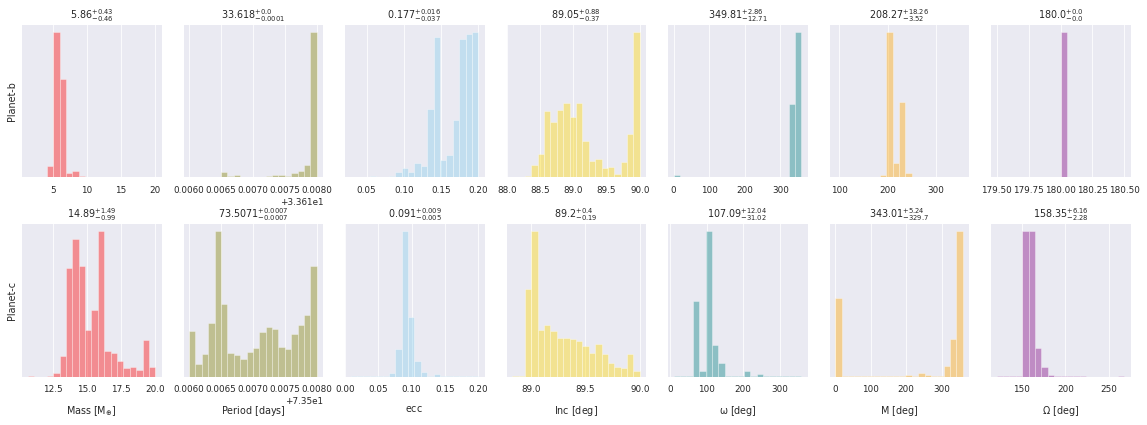

In [13]:
plots.plot_hist(PS, chains=fisicos, burning=0.8) #chains=results_dictionary['_chain'][T] hdf5_file='SystemX.hdf5', 

KeyboardInterrupt: 

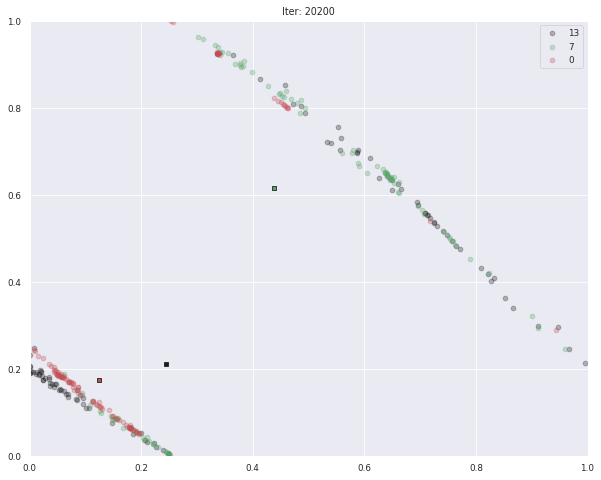

In [62]:
            if param_idx not in list(self.constant_params.keys()):
from IPython.display import display, clear_output
from nauyaca_local import utils
RESULTS = utils.get_mcmc_results(f'SystemX.hdf5')['CHAINS']


def plotear(x,y,steps,t,c):
    ax.scatter(RESULTS[t][:,steps,x], RESULTS[t][:,steps,y], alpha=0.3, label=f'{t}',c=c)
    plt.scatter(np.median(RESULTS[t][:,steps,x]),
                np.median(RESULTS[t][:,steps,y]), marker='s',c=c, edgecolors='k')
    return
for steps in range(int(itmax/conver_steps)):
    x, y = 10,11
    fig, ax = plt.subplots( figsize=(10,8))
    
    plotear(x,y,steps,13,'k')
    plotear(x,y,steps,7,'g')
    plotear(x,y,steps,0,'r')
        
    plt.legend()
    plt.title(f"Iter: {steps*conver_steps}")
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    #plt.axvline(68)
    #plt.axhline(15)
    
    display(fig)
    plt.close(fig)
    clear_output(wait=1) 

If you are interested in visualizing the chains movement just make a plot as 

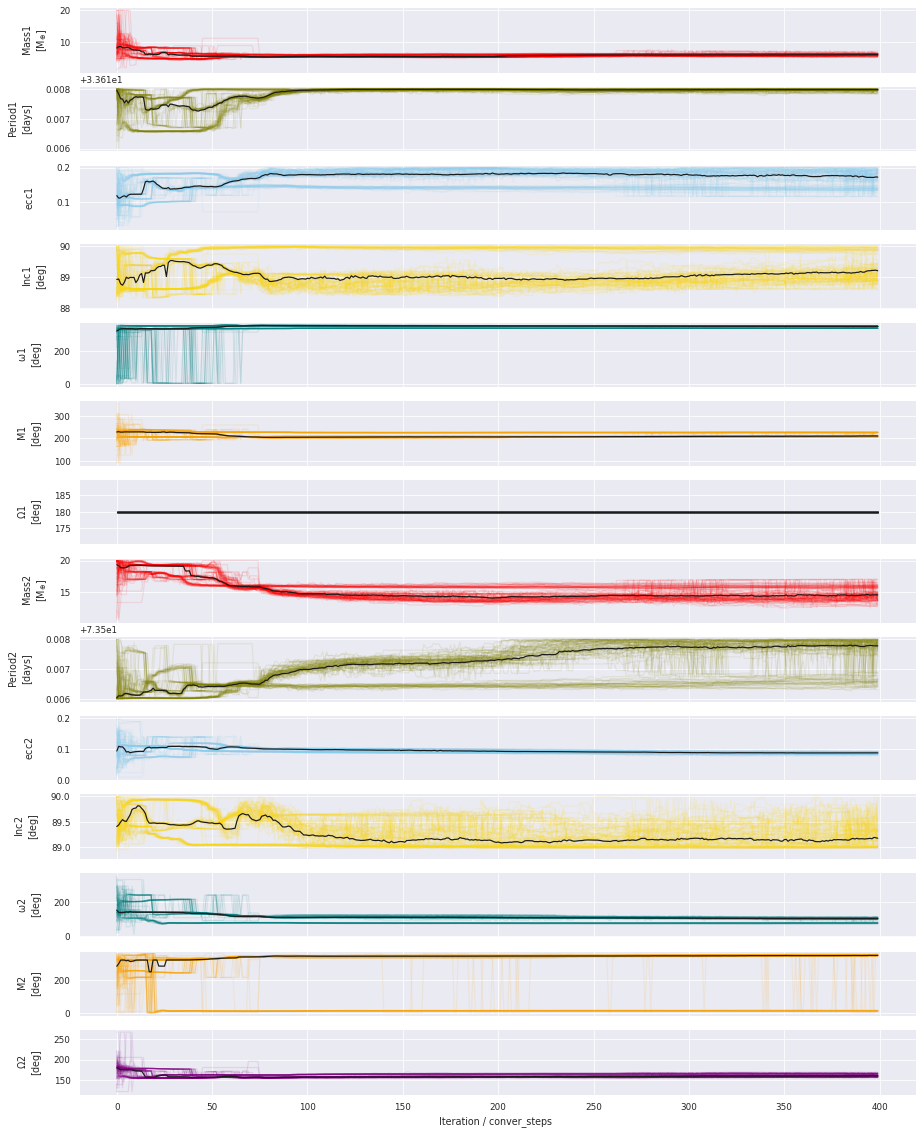

In [21]:
plots.plot_chains(PS, chains=fisicos, temperature=7, plot_means=True) #chains=results_dictionary['_chain'][T] hdf5_file='SystemX.hdf5',

And now a corner plot to visualize possible correlations between variables

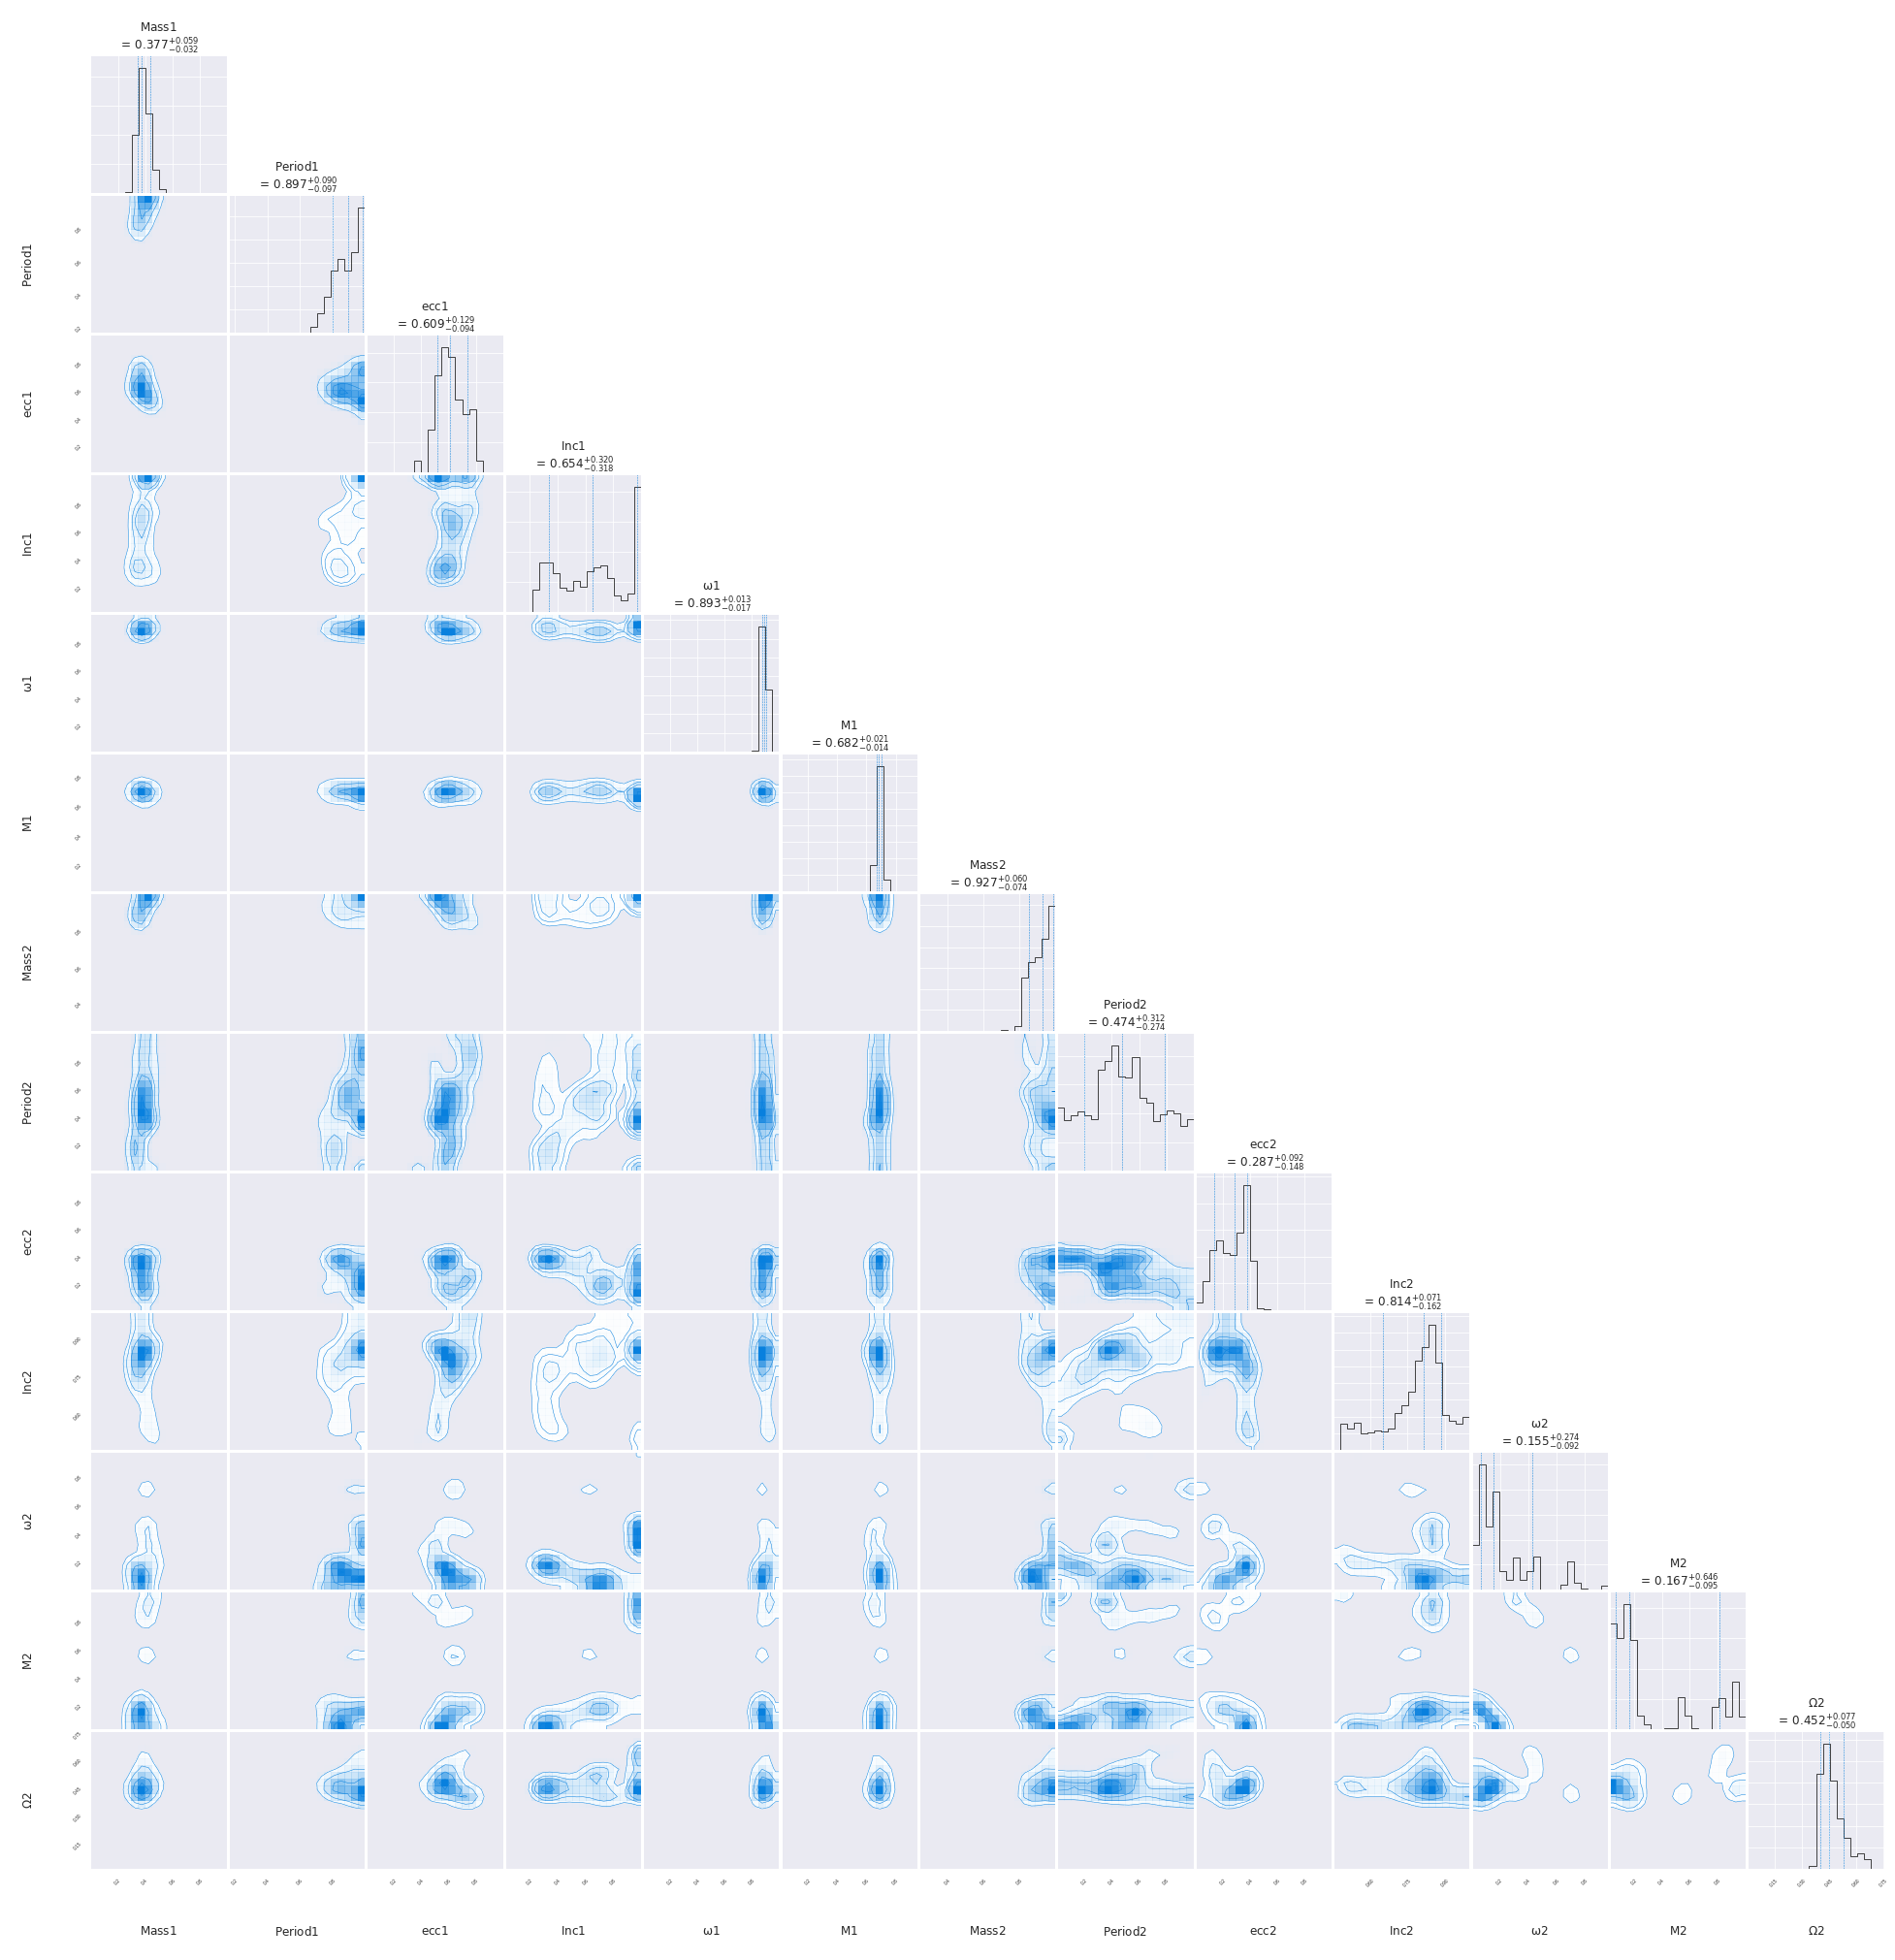

In [52]:
plots.plot_corner(PS, chains=results_dictionary['_chain'][T], burning=0.5)

### 3.2.1 The .hdf5 file

It is also possible to acces the main attributes of the MCMC sampler that are saved in the .hdf5 file. but first, let's print a summary of the posteriors which correspond to the median and 16th and 84th percentile as lower and upper errors

In [53]:
from nauyaca_local.utils import mcmc_summary

# burning argument is a fraction of the chains to discard in the burning phase. Let's remove first 50%
# verbose prints the summary
posteriors = mcmc_summary("SystemX.hdf5", burning=0.5, verbose=True)   

print('\n---RESULTS:')
posteriors

-->Planetary System:  SystemX
   Stellar mass:  0.91
   Stellar radius:  1.18
   Number of planets:  2
--------------------------
-->MCMC parameters
   Ntemps:  16
   Nwalkers per temperature:  100
   Number of iterations:  50000
   Thining:  50
--------------------------
      RESULTS             
-->Results in File:   SystemX.hdf5
-->Reference epoch of the solutions:  0  [JD]
-->Best solution in MCMC
   Best chi2 solution:  108.30638
   0.4744   0.8902   0.4894   0.2416   0.9037   0.6786   180.0
   0.9873   0.8023   0.3647   0.5009   0.214   0.0345   0.4517
--------------------------
-->MCMC medians and 1-sigma errors
             mass1      0.4 ^{+0.05}_{-0.04}
           period1      0.9286 ^{+0.0579}_{-0.0868} 
              ecc1      0.629 ^{+0.128}_{-0.124}
      inclination1      0.65 ^{+0.33}_{-0.33}
         argument1      0.9 ^{+0.01}_{-0.01}
     mean_anomaly1      0.68 ^{+0.01}_{-0.02}
             mass2      0.94 ^{+0.06}_{-0.09}
           period2      0.61 ^{+0.27}_{-0.

{'mass1': [0.39603550183673214],
 'mass1_e': [0.04183773767234383],
 'mass1_E': [0.0475183762583391],
 'period1': [0.9286418847326872],
 'period1_e': [0.08675324245185312],
 'period1_E': [0.057915638804613145],
 'ecc1': [0.6287053256079944],
 'ecc1_e': [0.1243376277459205],
 'ecc1_E': [0.12803215888642883],
 'inclination1': [0.6499596212240606],
 'inclination1_e': [0.3338125840090974],
 'inclination1_E': [0.32590929347372377],
 'argument1': [0.897159299362674],
 'argument1_e': [0.011919804585832638],
 'argument1_E': [0.01345024920761595],
 'mean_anomaly1': [0.6783037114476522],
 'mean_anomaly1_e': [0.021318983741766218],
 'mean_anomaly1_E': [0.012032861275375062],
 'mass2': [0.9381178900836873],
 'mass2_e': [0.09314267979090052],
 'mass2_E': [0.05604971940905912],
 'period2': [0.6056440224863529],
 'period2_e': [0.24709906680825555],
 'period2_E': [0.26980230356598656],
 'ecc2': [0.2930857284166232],
 'ecc2_e': [0.17527005359780157],
 'ecc2_E': [0.08179580899935496],
 'inclination2': [

Now, let's make available all the results saved in the .hdf5 file in a dictionary:

In [17]:
results_hdf5 =  nau.utils.get_mcmc_results('SystemX.hdf5')

print(results_hdf5.keys() )  # Attributes saved in the .hdf5 file

dict_keys(['ACC_FRAC0', 'AUTOCORR', 'BESTCHI2', 'BESTSOLS', 'BETAS', 'BOUNDS', 'CHAINS', 'COL_NAMES', 'CONVER_STEPS', 'CORES', 'INDEX', 'ITER_LAST', 'ITMAX', 'MEANCHI2', 'MSTAR', 'NAME', 'NPLA', 'NTEMPS', 'NWALKERS', 'POP0', 'REF_EPOCH', 'RSTAR', 'TAU_PROM0'])


These keys correspond to the main features of the MCMC saved in the .hdf5 file. This file is portable and is useful to restart an MCMC in other time or in another computer. 

Not all the attributes in results_dictionary are stored in the .hdf5 file but just those necessary to analize the MCMC performance and many properties of the planetary system. For example the 'CHAINS' key is the same as the attribute in results_dictionary['_chain'].

From the .hdf5 file it is also possible to monitor the MCMC behaviour using the prefabricated image

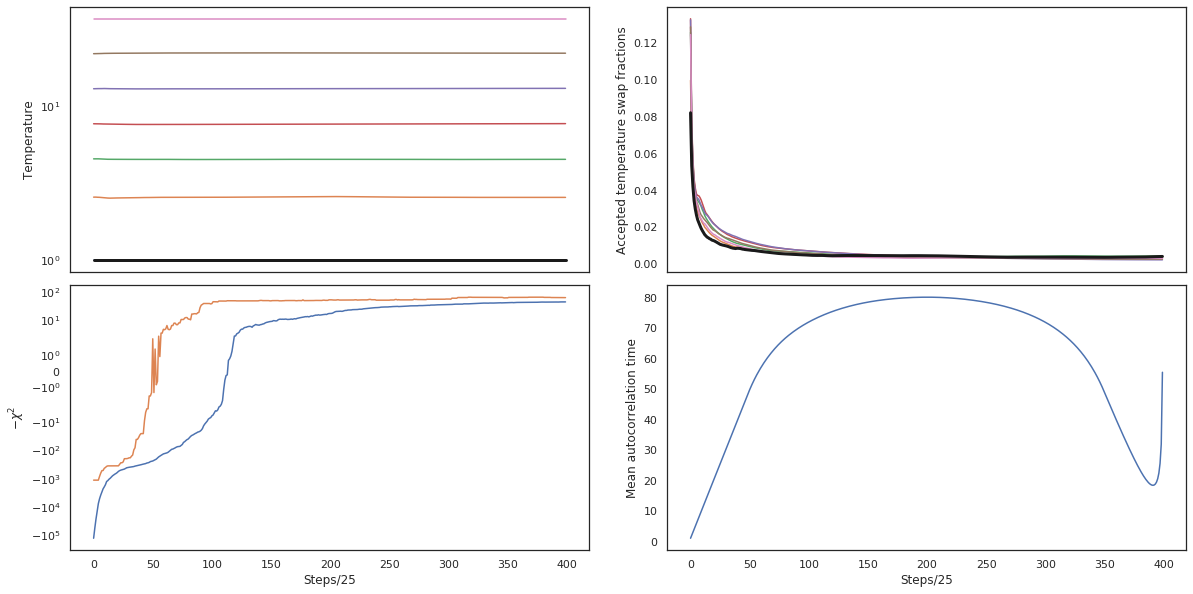

In [13]:
plots.plot_monitor('SystemX.hdf5')

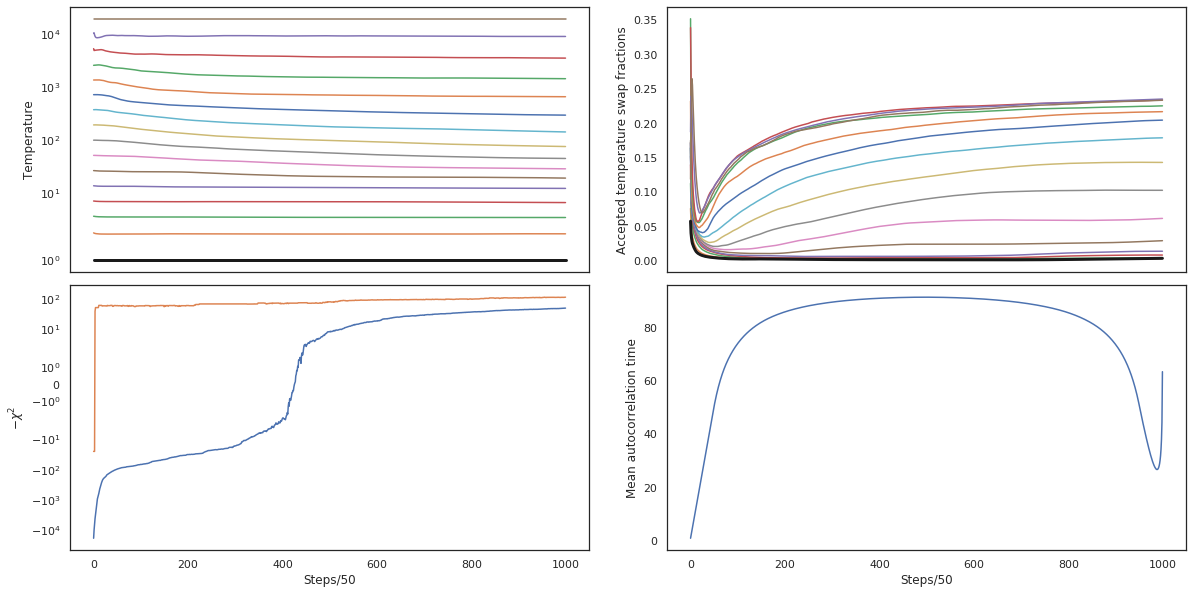

In [54]:
plots.plot_monitor('SystemX.hdf5')

### 3.2.2 The .best file

At the end of the iterations, best solutions are extracted automatically (corresponding to the solutions of 'better posterior' per step) and saved in a .best file. It's ordered by log-likelihood from higher to lower. If for any reason the mcmc run does not finish correctly or is interrupted, you can always extract the best solutions along the saved iterations by typing:

In [14]:
best_solutions = nau.utils.extract_best_solutions('SystemX.hdf5')

--> Best solutions from the SystemX.hdf5 will be written at: SystemX.best


Let's select the bet 5 solutions

In [16]:
# The best 5 results. Tuples are (loglikelihood, (solution))
best_n = best_solutions[0:1]
best_n

[(60.91305406270429,
  array([0.31227248, 0.98582177, 0.72347548, 0.89129363, 0.78238936,
         0.65430085, 0.78419371, 0.40758128, 0.41392945, 0.4970468 ,
         0.12407731, 0.59156745, 0.41051048]))]

## 3.3 Visualizing the TTVs

Let's plot the best 5 solutions found by the MCMC and stored in previous created variable 'best_n'

In [18]:
best_n[0][1]

array([0.31227248, 0.98582177, 0.72347548, 0.89129363, 0.78238936,
       0.65430085, 0.78419371, 0.40758128, 0.41392945, 0.4970468 ,
       0.12407731, 0.59156745, 0.41051048])

[array([0.31227248, 0.98582177, 0.72347548, 0.89129363, 0.78238936,
       0.65430085, 0.78419371, 0.40758128, 0.41392945, 0.4970468 ,
       0.12407731, 0.59156745, 0.41051048])]
[9.5409944369, 33.617780493194005, 0.09789057152671, 88.483274932, 325.32469776, 244.28017296000002, 180.0, 19.7474577366, 73.50760450894799, 0.07294658938818, 89.00186109, 77.04707364000001, 12.436040664, 171.31463424]


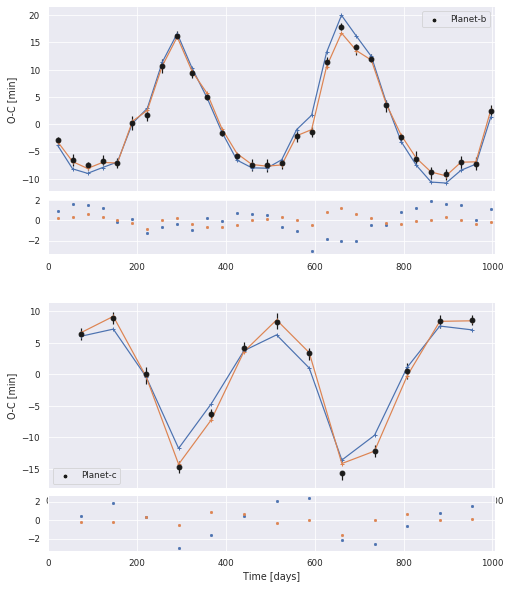

In [20]:
from nauyaca_local.plots import plot_TTVs

n = [solution[1] for solution in best_n]
print(n)

#
n = [4.74421831e-01, 8.90246597e-01, 4.89427329e-01, 2.41637466e-01,
         9.03679716e-01, 6.78556036e-01,  9.87309434e-01,
         8.02254474e-01, 3.64701182e-01, 5.00930545e-01, 2.14019649e-01,
         3.45445574e-02, 4.51747968e-01]

bi, bf = np.array(PS.bounds).T # hypercube
flat_params2 =  bi + n*(bf - bi)  

sol1 = list(flat_params2)             # hypercube cambie a 2
for k, v in sorted(PS.constant_params.items(), key=lambda j:j[0]):
    sol1.insert(k, v)
print(sol1)
#

sol = cube_to_physical(PS, best_n[0][1])

plot_TTVs(PS,[sol,  sol1], show_obs=True)